In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time

from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
time_start = time.time()

**Get packet features**

In [3]:
b = BLEPipeline()

In [4]:
# b.extract_packet_features(create_master=False)

**Produce dataframe**

In [4]:
df = b.make_dataframe()

August2    224739
Home1       58810
Home2       58614
Push        32761
Kevo        21107
August1     17314
Weather      8643
Room2        8133
Room1        7728
Door1        7374
Door2        4154
Name: Name, dtype: int64


**Prep dataframe**

In [5]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

Resampling: undersampling and oversampling

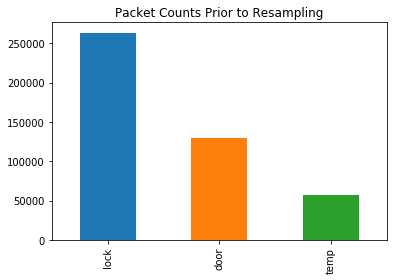

In [6]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#

devtype_df = df["DeviceType"].value_counts()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

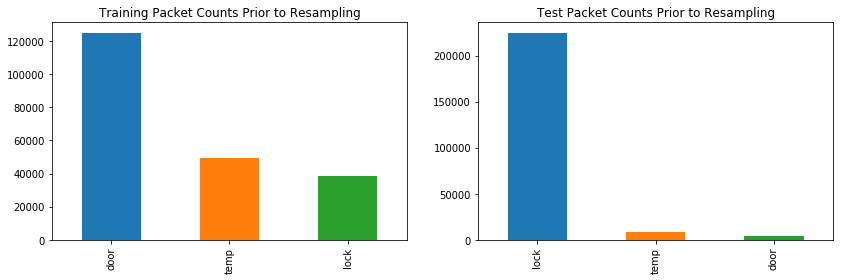

In [7]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
devtype_train = df_train["DeviceType"].value_counts()
plt.subplot(1, 2, 1) #
devtype_train.plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
devtype_test = df_test["DeviceType"].value_counts()
plt.subplot(1, 2, 2)
devtype_test.plot(kind='bar', title="Test Packet Counts Prior to Resampling");


In the training set, the 'door' class has the most packets, with the 'lock' class having the least. 
In the test set, the 'lock' class has the most packets, with the 'door' class having the least. 

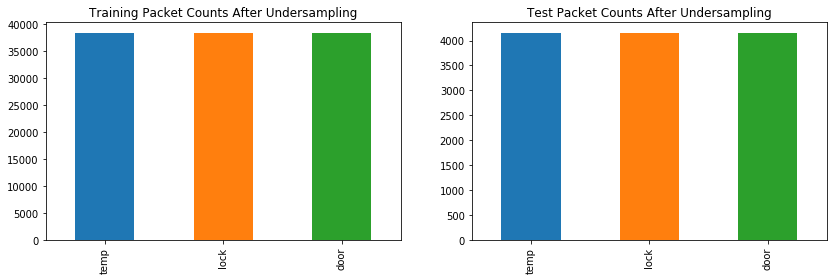

In [9]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

kind = "under"
category = "DeviceType"
df_train_undersampled = b.resample(df_train, kind=kind, category=category)
df_test_undersampled = b.resample(df_test, kind=kind, category=category)

# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

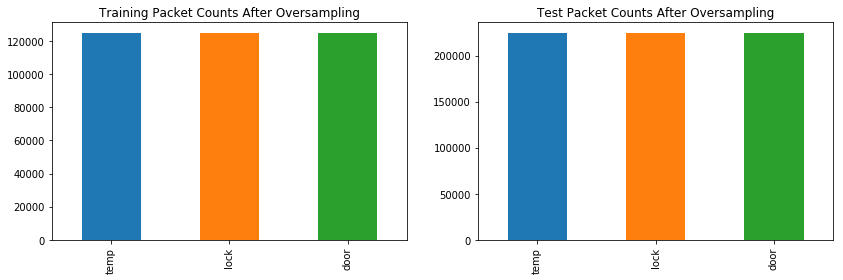

In [10]:
# 2nd technique - Random oversampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class
kind = "over"
category = "DeviceType"
df_train_oversampled = b.resample(df_train, kind=kind, category=category)
df_test_oversampled = b.resample(df_test, kind=kind, category=category)


# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Oversampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Oversampling");

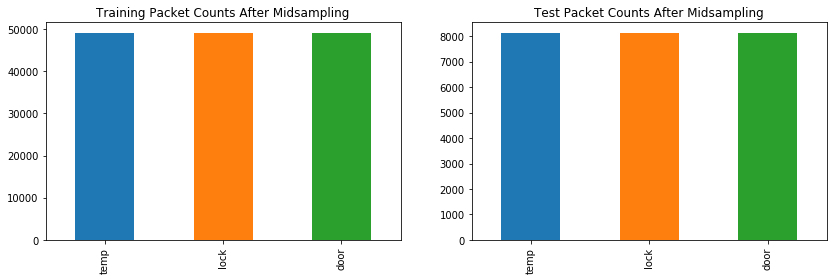

In [12]:
# 3rd technique - Random midsampling: 
kind = "mid"
category = "DeviceType"
df_train_midsampled = b.resample(df_train, kind=kind, category=category)
df_test_midsampled = b.resample(df_test, kind=kind, category=category)


# Plot changes
plt.subplots(1, 2, figsize=(14,4))

plt.subplot(1, 2, 1)
df_train_midsampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Midsampling");

plt.subplot(1, 2, 2)
df_test_midsampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Midsampling");

df_midsample = pd.concat([df_train_midsampled, df_test_midsampled], axis=0)

**Create feature list**

In [10]:
# Run One vs All  and One vs One classification strategies
features_list = [
#     'AccessAddr', 'AdvertAddr', 'ScanAddr',
    'BLE_LL_Length', 'TxAddr', 'CompanyID',
    'RFChannel',
    'PacketLength', 'Time', 'Assoc_Packets',
    'ADV_DIRECT_IND', 'ADV_IND', 'ADV_NONCONN_IND', 
    'ADV_SCAN_IND', 'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP']

y_list = ["door", "lock", "temp"]

**Run classification algorithms**

Testing cm_metrics

In [14]:
def test_make_conf_matrix(y_actual, y_pred, cm_type, labels=None):
        """
        Returns a confusion matrix.
        
        Parameters
        ----------
        y_actual: the true values for y
        y_pred: the predicted values for y produced by the classifier
        labels: the labels of y
        
        Returns
        -------
        df_confusion (df): a confusion matrix with the true positive, false positive, true negative and false negative counts
        """
        # Multiclass is used for multiple classes
        if cm_type == 'multiclass':
            # Decode device type from actual and predicted lists
            df_actual = pd.DataFrame(y_actual, columns=labels, dtype=int)
            df_preds = pd.DataFrame(y_pred, columns=labels, dtype=int)
            
        # Singleclass is used in binary classification
        elif cm_type == 'binary':
            # Create array for the non-class 
            # i.e. if an observation is a positive class, the non-class will be negative
            y_actual_nonclass = np.logical_not(y_actual).astype(int)        
            y_pred_nonclass = np.logical_not(y_pred).astype(int)
            
            # Combine positive and nonclass into dfs
            if labels != None:
                # Use labels
                df_actual = pd.DataFrame({labels[0]: y_actual, labels[1]:y_actual_nonclass})        
                df_preds = pd.DataFrame({labels[0]: y_pred, labels[1]:y_pred_nonclass})
            else:
                # Use "not" label
                df_actual = pd.DataFrame({y_actual.name: y_actual, str('not' + y_actual.name):y_actual_nonclass})        
                df_preds = pd.DataFrame({y_actual.name: y_pred, str('not' + y_actual.name):y_pred_nonclass})

        else:
            print "Invalid confusion matrix type"
            return
        
        # Create column containing the response variable
        df_actual["Response"] = (df_actual.iloc[:] == 1).idxmax(1)
        df_preds["Response"] = (df_preds.iloc[:] == 1).idxmax(1)  
        
        # Put into numpy array for easy manipulation into crosstab
        actual = np.array(df_actual["Response"])
        pred = np.array(df_preds["Response"])        
        
        df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
        
        # Ensure that df_confusion is square
        if len(df_confusion.columns) != len(df_confusion.index):
            # Get set of column and index entries
            columns = set(df_confusion.columns)
            rows = set(df_confusion.index)

            # Find which entries are missing from both columns and indices
            missing_columns = rows - columns
            missing_rows = columns - rows

            # Create array of padded zeros
            len_longSide = max(len(columns), len(rows))
            zeros = np.zeros((len_longSide,1), dtype=np.int)    

            # Fill with column/rows
            for column in missing_columns:
                df_confusion[column] = zeros
            for row in missing_rows:
                # For rows, transpose df first to allow easy concat
                temp_cm = df_confusion.transpose()
                temp_cm[row] = zeros
                df_confusion = temp_cm.transpose()
            
        return df_confusion

In [15]:
def test_one_vs_all_classify(df, features_list, y_list):
    time_start = time.time()

    # Divide df by train and test devices
    df_test = df[df["Set"]=="test"]
    df_train = df[df["Set"]=="train"]

    # Train using chosen features
    X_train = df_train[features_list]
    X_test = df_test[features_list]

    for device_type in y_list:
        # Set one device type as y
        y_train = df_train[device_type]
        y_test = df_test[device_type]

        time_start_clf = time.time()

        rf_clf = b.random_forest_classifier(X_train, y_train, X_test, y_test)
        knn_clf = b.k_neighbors_classifier(X_train, y_train, X_test, y_test)
        lda_clf = b.lda_classifier(X_train, y_train, X_test, y_test)

        time_elapsed_clf = time.time() - time_start_clf

#            print "Random Forest Score:", rf_clf['Score'], "Time: ", rf_clf['Time']
#            print "KNN Score:", knn_clf['Score'], "Time: ", knn_clf['Time']
#            print "LDA Score:", lda_clf['Score'], "Time: ", lda_clf['Time']

        # Get confusion matrices
        rf_cm = test_make_conf_matrix(y_test, rf_clf['Pred'], cm_type='binary')
        knn_cm = test_make_conf_matrix(y_test, knn_clf['Pred'], cm_type='binary')
        lda_cm = test_make_conf_matrix(y_test, lda_clf['Pred'], cm_type='binary')

        # Calculate metrics
        rf_metrics = test_calculate_cm_metrics(rf_cm)
        knn_metrics = test_calculate_cm_metrics(knn_cm)
        lda_metrics = test_calculate_cm_metrics(lda_cm)

        #Print outs
        print "Device Pair:", device_pair
        print "--------------------------"
        print "RF Confusion Matrix\n", rf_cm, '\n'   
        print "RF Metrics\n", rf_metrics, '\n'            
        print "KNN Confusion Matrix\n", knn_cm, '\n'
        print "KNN Metrics\n", knn_metrics, '\n'
        print "LDA Confusion Matrix\n", lda_cm, '\n'
        print "LDA Metrics\n", lda_metrics, '\n'

        print "Total time (classifiers):", time_elapsed_clf
        print ""

    print "Total time (one vs all_classify):", time.time() - time_start
    print ""  

In [16]:
def test_one_vs_one_classify(df, features_list, y_list):
        from itertools import combinations
        
        time_start = time.time()
        
        # Get possible combinations for one vs one
        combinations = [combination for combination in combinations(y_list, 2)]
    
        for device_pair in combinations:
            # Only use data with the two device types needed for one vs one classification
            pos_device_type = device_pair[0]
            neg_device_type = device_pair[1]
            df_1v1 = df[(df["DeviceType"]==pos_device_type) | (df["DeviceType"]==neg_device_type)]
    
            # Separate df into train and test sets
            df_train = df_1v1[df_1v1["Set"]=="train"]
            df_test = df_1v1[df_1v1["Set"]=="test"]
            X_train = df_train[features_list]
            X_test = df_test[features_list]
            y_train = df_train[pos_device_type]
            y_test = df_test[pos_device_type]
            
            time_start_clf = time.time()
            
            # Run classifiers
            rf_clf = b.random_forest_classifier(X_train, y_train, X_test, y_test)
            knn_clf = b.k_neighbors_classifier(X_train, y_train, X_test, y_test)
            lda_clf = b.lda_classifier(X_train, y_train, X_test, y_test)
    
            time_elapsed_clf = time.time() - time_start_clf
    
            
            # Get confusion matrices
            rf_cm = test_make_conf_matrix(y_test, rf_clf['Pred'], cm_type='binary', labels=device_pair)
            knn_cm = test_make_conf_matrix(y_test, knn_clf['Pred'], cm_type='binary', labels=device_pair)
            lda_cm = test_make_conf_matrix(y_test, lda_clf['Pred'], cm_type='binary', labels=device_pair)

            #Print outs
            print "Device Pair:", device_pair
            print "--------------------------"

            rf_metrics = test_calculate_cm_metrics(rf_cm)
            knn_metrics = test_calculate_cm_metrics(knn_cm)
            lda_metrics = test_calculate_cm_metrics(lda_cm)
            
            print "RF Confusion Matrix\n", rf_cm, '\n'   
            print "RF Metrics\n", rf_metrics, '\n'            
            print "KNN Confusion Matrix\n", knn_cm, '\n'
            print "KNN Metrics\n", knn_metrics, '\n'
            print "LDA Confusion Matrix\n", lda_cm, '\n'
            print "LDA Metrics\n", lda_metrics, '\n'
            
            print "Total time (classifiers):", time_elapsed_clf
            print ""
        
        print "Total time (one vs one_classify):", time.time() - time_start
        print ""        

In [17]:
def test_calculate_cm_metrics(conf_matrix):
        # Extract the counts
        fp = np.array(conf_matrix.sum(axis=0) - np.diag(conf_matrix))
        fn = np.array(conf_matrix.sum(axis=1) - np.diag(conf_matrix))
        tp = np.diag(conf_matrix)
        tn = np.array(conf_matrix.values.sum() - (fp + fn + tp))
        
        # Put data into dataframe for easy storage
        cm_metrics = pd.DataFrame({'TP':tp, 'FP':fp, 'TN':tn, 'FN':fn}, index=list(conf_matrix.columns))
    
        # Calculate metrics
        cm_metrics["Accuracy"] = (cm_metrics["TP"] + cm_metrics["TN"]) / cm_metrics.iloc[0:3].sum(axis=1)
        cm_metrics["Precision"] = cm_metrics["TP"] / (cm_metrics["TP"] + cm_metrics["FP"])
        cm_metrics["Recall"] = cm_metrics["TP"] / (cm_metrics["TP"] + cm_metrics["FN"])
    
        return cm_metrics

In [18]:
# Prep debug classifier: keep for future debugging
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
device_pair = ('door', 'lock')
pos_device_type = device_pair[0]
neg_device_type = device_pair[1]
df_1v1 = df_undersample[(df_undersample["DeviceType"]==pos_device_type) | (df_undersample["DeviceType"]==neg_device_type)]

# Separate df into train and test sets
df_train = df_1v1[df_1v1["Set"]=="train"]
df_test = df_1v1[df_1v1["Set"]=="test"]
X_train = df_train[features_list]
X_test = df_test[features_list]
y_train = df_train[pos_device_type]
y_test = df_test[pos_device_type]
y_test = df_test[pos_device_type]

lda_clf = b.lda_classifier(X_train, y_train, X_test, y_test)
lda_cm = test_make_conf_matrix(y_test, lda_clf['Pred'], cm_type='binary', labels=device_pair)
display(lda_cm)

Predicted,door,lock
Actual,,
door,4154,0
lock,4154,0


In [19]:
# Debug: test seaborn plots for cm and cm metrics
# Seaborn CM


Resampling by DeviceType

In [20]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs one: undersampling by DeviceType\n"
# test_one_vs_one_classify(df_undersample, features_list, y_list)
b.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by DeviceType

Device Pair: ('door', 'lock')
--------------------------
RF Confusion Matrix
Predicted  door  lock
Actual               
door       4154     0
lock       4033   121 

RF Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door     0  4033   121  4154  0.514564    0.50739  1.000000
lock  4033     0  4154   121  0.514564    1.00000  0.029129 

KNN Confusion Matrix
Predicted  door  lock
Actual               
door       1129  3025
lock          9  4145 

KNN Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door  3025     9  4145  1129   0.63481   0.992091  0.271786
lock     9  3025  1129  4145   0.63481   0.578103  0.997833 

LDA Confusion Matrix
Predicted  door  lock
Actual               
door       4154     0
lock       4154     0 

LDA Metrics
        FN    FP    TN    TP  Accuracy  Precision  Recall
door     0  4154     0  4154       0.5        0.5     1.0
lock  4154     0  4154     0       0.5        NaN     0

In [21]:
df_undersample = pd.concat([df_train_undersampled, df_test_undersampled], axis=0)
print "One vs all: undersampling by DeviceType\n"
# test_one_vs_all_classify(df_undersample, features_list, y_list)
b.one_vs_all_classify(df_undersample, features_list, y_list)

One vs all: undersampling by DeviceType

Device Type: door
RF Confusion Matrix
Predicted  door  notdoor
Actual                  
door       1154     3000
notdoor    4000     4308
RF Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door     3000  4000  4308  1154  0.438292   0.223904  0.277805
notdoor  4000  3000  1154  4308  0.438292   0.589491  0.518536
KNN Confusion Matrix
Predicted  door  notdoor
Actual                  
door        101     4053
notdoor      84     8224
KNN Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door     4053    84  8224   101  0.668031   0.545946  0.024314
notdoor    84  4053   101  8224  0.668031   0.669870  0.989889
LDA Confusion Matrix
Predicted  door  notdoor
Actual                  
door          1     4153
notdoor    4155     4153
LDA Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door     4153  4155  4153     1  0.333333   0.000241  0.000241
notdoor  4155  4153     1  4153  0.33333

In [22]:
df_oversample = pd.concat([df_train_oversampled, df_test_oversampled], axis=0)
print "One vs one: oversampling by DeviceType\n"
# test_one_vs_one_classify(df_oversample, features_list, y_list)
b.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by DeviceType

Device Pair: ('door', 'lock')
--------------------------
RF Confusion Matrix
Predicted    door   lock
Actual                  
door       224739      0
lock       208464  16275 

RF Metrics
          FN      FP      TN      TP  Accuracy  Precision    Recall
door       0  208464   16275  224739  0.536209   0.518784  1.000000
lock  208464       0  224739   16275  0.536209   1.000000  0.072417 

KNN Confusion Matrix
Predicted    door    lock
Actual                   
door       176237   48502
lock          481  224258 

KNN Metrics
         FN     FP      TN      TP  Accuracy  Precision    Recall
door  48502    481  224258  176237  0.891022   0.997278  0.784185
lock    481  48502  176237  224258  0.891022   0.822181  0.997860 

LDA Confusion Matrix
Predicted    door  lock
Actual                 
door       224739     0
lock       224734     5 

LDA Metrics
          FN      FP      TN      TP  Accuracy  Precision    Recall
door       0  224734      

In [23]:
print "One vs all: oversampling by DeviceType\n"
b.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by DeviceType

Device Type: door
RF Confusion Matrix
Predicted    door  notdoor
Actual                    
door        58764   165975
notdoor    213427   236051
RF Metrics
             FN      FP      TN      TP  Accuracy  Precision    Recall
door     165975  213427  236051   58764   0.43727   0.215893  0.261477
notdoor  213427  165975   58764  236051   0.43727   0.587154  0.525167
KNN Confusion Matrix
Predicted   door  notdoor
Actual                   
door       34054   190685
notdoor    30933   418545
KNN Metrics
             FN      FP      TN      TP  Accuracy  Precision    Recall
door     190685   30933  418545   34054  0.671296   0.524012  0.151527
notdoor   30933  190685   34054  418545  0.671296   0.687007  0.931180
LDA Confusion Matrix
Predicted    door  notdoor
Actual                    
door           54   224685
notdoor    224757   224721
LDA Metrics
             FN      FP      TN      TP  Accuracy  Precision   Recall
door     224685  224757  2247

In [17]:
print "One vs one: midsampling by DeviceType\n"
b.one_vs_one_classify(df_midsample, features_list, y_list);

One vs one: midsampling by DeviceType

Device Pair: ('door', 'lock')
--------------------------
--------------------------
RF Confusion Matrix
Predicted  door  lock
Actual               
door       8125     8
lock         13  8120 

RF Metrics
      FN  FP    TN    TP  Accuracy  Precision    Recall
door   8  13  8120  8125  0.998709   0.998403  0.999016
lock  13   8  8125  8120  0.998709   0.999016  0.998402 

--------------------------
KNN Confusion Matrix
Predicted  door  lock
Actual               
door       1729  6404
lock          9  8124 

KNN Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door  6404     9  8124  1729  0.605742   0.994822  0.212591
lock     9  6404  1729  8124  0.605742   0.559196  0.998893 

--------------------------
LDA Confusion Matrix
Predicted  door  lock
Actual               
door       8133     0
lock       8133     0 

LDA Metrics
        FN    FP    TN    TP  Accuracy  Precision  Recall
door     0  8133     0  8133       0.5        

In [18]:
print "One vs all: midsampling by DeviceType\n"
b.one_vs_all_classify(df_midsample, features_list, y_list);

One vs all: midsampling by DeviceType

Device Type: door
RF

Confusion Matrix
Predicted  door   rest
Actual                
door        660   7473
rest        702  15564

Metrics
        FN    FP     TN     TP  Accuracy  Precision    Recall
door  7473   702  15564    660  0.664945   0.484581  0.081151
rest   702  7473    660  15564  0.664945   0.675609  0.956842
---------------------------------------------------------
KNN

Confusion Matrix
Predicted  door   rest
Actual                
door        137   7996
rest        113  16153

Metrics
        FN    FP     TN     TP  Accuracy  Precision    Recall
door  7996   113  16153    137   0.66765   0.548000  0.016845
rest   113  7996    137  16153   0.66765   0.668889  0.993053
---------------------------------------------------------
LDA

Confusion Matrix
Predicted  door  rest
Actual               
door          3  8130
rest       8134  8132

Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door  8130  8134  8132     3  0

Resampling by Name

In [24]:
df_undersample = df_name_undersample
print "One vs one: undersampling by Name\n"
b.one_vs_one_classify(df_undersample, features_list, y_list)

One vs one: undersampling by Name

Device Pair: ('door', 'lock')
--------------------------
RF Confusion Matrix
Predicted  door  lock
Actual               
door       4152     2
lock       4146     8 

RF Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door     2  4146     8  4152  0.500722   0.500362  0.999519
lock  4146     2  4152     8  0.500722   0.800000  0.001926 

KNN Confusion Matrix
Predicted  door  lock
Actual               
door       3524   630
lock          7  4147 

KNN Metrics
       FN   FP    TN    TP  Accuracy  Precision    Recall
door  630    7  4147  3524  0.923327   0.998018  0.848339
lock    7  630  3524  4147  0.923327   0.868118  0.998315 

LDA Confusion Matrix
Predicted  door  lock
Actual               
door       4154     0
lock       4152     2 

LDA Metrics
        FN    FP    TN    TP  Accuracy  Precision    Recall
door     0  4152     2  4154  0.500241    0.50012  1.000000
lock  4152     0  4154     2  0.500241    1.00000  0.000481 

T

In [25]:
print "One vs All: undersampling by Name\n"
b.one_vs_all_classify(df_undersample, features_list, y_list)

One vs All: undersampling by Name

Device Type: door
RF Confusion Matrix
Predicted  door  notdoor
Actual                  
door       3502      652
notdoor    7611      697
RF Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door      652  7611   697  3502  0.336944   0.315126  0.843043
notdoor  7611   652  3502   697  0.336944   0.516679  0.083895
KNN Confusion Matrix
Predicted  door  notdoor
Actual                  
door        909     3245
notdoor     786     7522
KNN Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door     3245   786  7522   909  0.676537   0.536283  0.218825
notdoor   786  3245   909  7522  0.676537   0.698616  0.905392
LDA Confusion Matrix
Predicted  door  notdoor
Actual                  
door         11     4143
notdoor    4164     4144
LDA Metrics
           FN    FP    TN    TP  Accuracy  Precision    Recall
door     4143  4164  4144    11  0.333414   0.002635  0.002648
notdoor  4164  4143    11  4144  0.333414   0.

In [26]:
df_oversample = df_name_oversample
print "One vs one: oversampling by Name\n"
b.one_vs_one_classify(df_oversample, features_list, y_list)

One vs one: oversampling by Name

Device Pair: ('door', 'lock')
--------------------------
RF Confusion Matrix
Predicted    door   lock
Actual                  
door       224627    112
lock       159791  64948 

RF Metrics
          FN      FP      TN      TP  Accuracy  Precision    Recall
door     112  159791   64948  224627  0.644247   0.584330  0.999502
lock  159791     112  224627   64948  0.644247   0.998279  0.288993 

KNN Confusion Matrix
Predicted    door    lock
Actual                   
door       221919    2820
lock          494  224245 

KNN Metrics
        FN    FP      TN      TP  Accuracy  Precision    Recall
door  2820   494  224245  221919  0.992627   0.997779  0.987452
lock   494  2820  221919  224245  0.992627   0.987581  0.997802 

LDA Confusion Matrix
Predicted    door  lock
Actual                 
door       224739     0
lock       224737     2 

LDA Metrics
          FN      FP      TN      TP  Accuracy  Precision    Recall
door       0  224737       2  224739  

In [27]:
print "One vs all: oversampling by Name\n"
b.one_vs_all_classify(df_oversample, features_list, y_list)

One vs all: oversampling by Name

Device Type: door
RF Confusion Matrix
Predicted    door  notdoor
Actual                    
door       210873    13866
notdoor    426396    23082
RF Metrics
             FN      FP      TN      TP  Accuracy  Precision    Recall
door      13866  426396   23082  210873  0.347003   0.330901  0.938302
notdoor  426396   13866  210873   23082  0.347003   0.624716  0.051353
KNN Confusion Matrix
Predicted    door  notdoor
Actual                    
door       105015   119724
notdoor     99075   350403
KNN Metrics
             FN      FP      TN      TP  Accuracy  Precision    Recall
door     119724   99075  350403  105015  0.675477   0.514552  0.467275
notdoor   99075  119724  105015  350403  0.675477   0.745337  0.779578
LDA Confusion Matrix
Predicted    door  notdoor
Actual                    
door          589   224150
notdoor    225094   224384
LDA Metrics
             FN      FP      TN      TP  Accuracy  Precision    Recall
door     224150  225094  22438

**Time Metrics**

In [28]:
print "Total time:", time.time() - time_start

Total time: 10536.903703
